In [ ]:
!pip install keras-tuner
!pip install tensorflow
!pip install np_utils

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import IPython.display as ipd
import librosa
import librosa.display

import scipy.io.wavfile
from scipy import signal

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow
from tensorflow import keras
import keras_tuner
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, Dropout, ReLU, Softmax, BatchNormalization, Activation, Conv1D, MaxPooling1D
from keras import optimizers
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

%matplotlib inline
plt.rcParams.update({"axes.labelsize":16, "xtick.labelsize":14, "ytick.labelsize":14, "axes.titlesize":16})

In [ ]:
#os.chdir('/content/drive/My Drive/Speech Emotion Recognition/ravdess-data/')

In [ ]:
!ls -lhtr

total 8.0K
drwxr-xr-x 1 root root 4.0K Apr  8 13:32 sample_data
drwx------ 5 root root 4.0K Apr 20 22:06 drive


In [ ]:
dataPaths = ["/content/drive/My Drive/Speech Emotion Recognition/ravdess-data/","/content/drive/My Drive/Speech Emotion Recognition/ravdess-data/"]
#dataPaths = os.getcwd()
dir_list = os.listdir(dataPaths[0])
dir_list.sort()
#dir_list.pop(0)  # Removing ".DS_Store" file in local system
print(dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [ ]:
#audioData = pd.DataFrame(columns=["File","Actor","Gender","Emotion_Value","Emotion_Label"])

In [ ]:
# Create DataFrame for Data intel
audioData = pd.DataFrame(columns=['path','source','actor', 'gender', 'emotion','emotion_lb'])
count = 0

for dir in dataPaths:
    dir_list = os.listdir(dir)
    dir_list.sort()
    for i in dir_list:
      file_list = os.listdir(dir + "/" + i)
      for f in file_list:
          nm = f.split('.')[0].split('-')
          path = dir + "/" + i + '/' + f
          src = int(nm[1])
          actor = int(nm[-1])
          emotion = int(nm[2])
          source = "Ravdess"

          if int(actor)%2 == 0:
              gender = "female"
          else:
              gender = "male"

          if nm[3] == '01':
              intensity = 0
          else:
              intensity = 1

          if nm[4] == '01':
              statement = 0
          else:
              statement = 1

          if nm[5] == '01':
              repeat = 0
          else:
              repeat = 1

          if emotion == 1:
              lb = "neutral"
          elif emotion == 2:
              lb = "calm"
          elif emotion == 3:
              lb = "happy"
          elif emotion == 4:
              lb = "sad"
          elif emotion == 5:
              lb = "angry"
          elif emotion == 6:
              lb = "fearful"
          elif emotion == 7:
              lb = "disgust"
          elif emotion == 8:
              lb = "surprised"
          else:
              lb = "none"

          audioData.loc[count] = [path,source,actor, gender, emotion,lb]
          count += 1

In [ ]:
file_list

['03-01-08-01-02-02-24.wav',
 '03-01-03-02-01-02-24.wav',
 '03-01-04-02-01-02-24.wav',
 '03-01-03-02-02-01-24.wav',
 '03-01-05-01-02-01-24.wav',
 '03-01-01-01-01-02-24.wav',
 '03-01-04-02-02-01-24.wav',
 '03-01-04-02-01-01-24.wav',
 '03-01-02-02-02-01-24.wav',
 '03-01-06-02-02-01-24.wav',
 '03-01-06-01-02-01-24.wav',
 '03-01-04-01-01-02-24.wav',
 '03-01-08-02-01-01-24.wav',
 '03-01-07-01-01-01-24.wav',
 '03-01-01-01-02-02-24.wav',
 '03-01-07-02-01-02-24.wav',
 '03-01-02-02-02-02-24.wav',
 '03-01-07-01-02-02-24.wav',
 '03-01-08-01-01-02-24.wav',
 '03-01-08-02-01-02-24.wav',
 '03-01-04-01-02-01-24.wav',
 '03-01-06-02-01-01-24.wav',
 '03-01-05-02-02-01-24.wav',
 '03-01-06-02-02-02-24.wav',
 '03-01-05-02-01-01-24.wav',
 '03-01-04-01-02-02-24.wav',
 '03-01-04-02-02-02-24.wav',
 '03-01-07-02-02-01-24.wav',
 '03-01-03-01-02-02-24.wav',
 '03-01-07-01-02-01-24.wav',
 '03-01-05-02-02-02-24.wav',
 '03-01-07-02-01-01-24.wav',
 '03-01-01-01-02-01-24.wav',
 '03-01-02-01-01-02-24.wav',
 '03-01-07-02-

In [ ]:
dir_list

['Actor_01',
 'Actor_02',
 'Actor_03',
 'Actor_04',
 'Actor_05',
 'Actor_06',
 'Actor_07',
 'Actor_08',
 'Actor_09',
 'Actor_10',
 'Actor_11',
 'Actor_12',
 'Actor_13',
 'Actor_14',
 'Actor_15',
 'Actor_16',
 'Actor_17',
 'Actor_18',
 'Actor_19',
 'Actor_20',
 'Actor_21',
 'Actor_22',
 'Actor_23',
 'Actor_24']

In [ ]:
audioData.head()

,path,source,actor,gender,emotion,emotion_lb
0,/content/drive/My Drive/Speech Emotion Recogni...,Ravdess,1,male,5,angry
1,/content/drive/My Drive/Speech Emotion Recogni...,Ravdess,1,male,7,disgust
2,/content/drive/My Drive/Speech Emotion Recogni...,Ravdess,1,male,5,angry
3,/content/drive/My Drive/Speech Emotion Recogni...,Ravdess,1,male,7,disgust
4,/content/drive/My Drive/Speech Emotion Recogni...,Ravdess,1,male,4,sad


In [ ]:
audioData.sort_values(by='path',inplace=True)
audioData.index = range(len(audioData.index))
audioData.head()

,path,source,actor,gender,emotion,emotion_lb
0,/content/drive/My Drive/Speech Emotion Recogni...,Ravdess,1,male,1,neutral
1,/content/drive/My Drive/Speech Emotion Recogni...,Ravdess,1,male,1,neutral
2,/content/drive/My Drive/Speech Emotion Recogni...,Ravdess,1,male,1,neutral
3,/content/drive/My Drive/Speech Emotion Recogni...,Ravdess,1,male,1,neutral
4,/content/drive/My Drive/Speech Emotion Recogni...,Ravdess,1,male,1,neutral


In [ ]:
audioData["actor"].unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24], dtype=object)

In [ ]:
audioData.shape

(2880, 6)

<font size=3>Since this is a continuous audio signal, we would define a sample rate which converts into discrete signal with set of sample in a second</font>

In [ ]:
sample_rate = 44100

In [ ]:
fileFullPath = dir[0] + audioData.loc[0, "path"]
samples, sample_rate = librosa.load(fileFullPath, res_type="kaiser_fast", sr=sample_rate)

In [ ]:
print(fileFullPath)

//content/drive/My Drive/Speech Emotion Recognition/ravdess-data//Actor_01/03-01-01-01-01-01-01.wav


In [ ]:
ipd.Audio(samples, rate=sample_rate)

In [ ]:
samples.shape

(145677,)

***

<font size=3>We will plot a Waveform and Spectogram of the audio signal so that we can understand the amplitude and frequencies in the audio clip.

For this purpose, we define a function which outputs frequencies, times and spectograms and can be used for all type of samples later on.</font>

***

In [ ]:
def plotSpectogram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

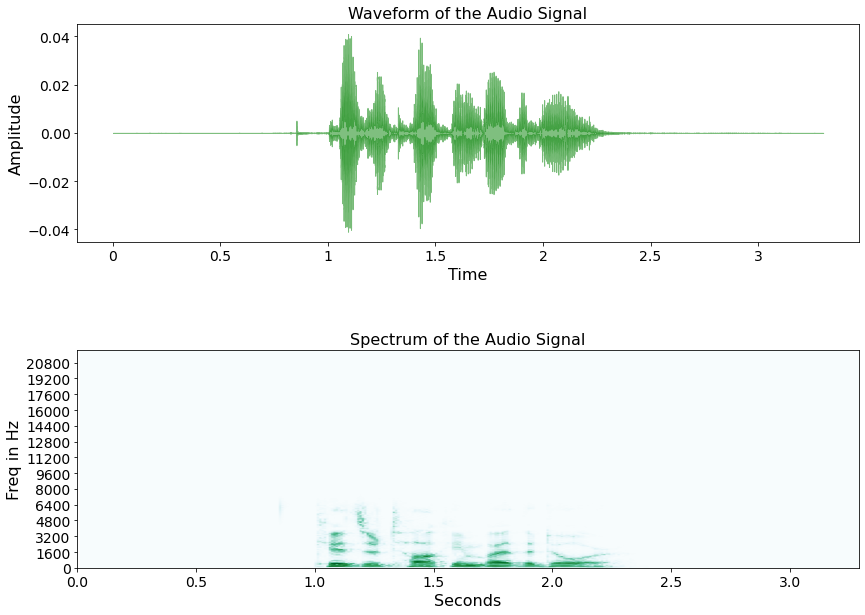

In [ ]:
freqs, times, spectograms = plotSpectogram(samples, sample_rate)


fig = plt.figure(figsize=(14,10));
ax1 = fig.add_subplot(211);
ax1.set_title("Waveform of the Audio Signal");
ax1.set_ylabel("Amplitude");
librosa.display.waveshow(samples, sr=sample_rate, color="Green", alpha=0.5);
fig.subplots_adjust(hspace=0.5);
ax2 = fig.add_subplot(212);
ax2.imshow(spectograms.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()], cmap="BuGn");
ax2.set_yticks(freqs[::32])
start, end = ax2.get_xlim();
ax2.xaxis.set_ticks(np.arange(0.0, end, 0.5));
ax2.set_title("Spectrum of the Audio Signal");
ax2.set_ylabel("Freq in Hz");
ax2.set_xlabel("Seconds");

<h2><u>Trimming Audio Signal</u></h2>

<font size=3>We will trim the audio in order to remove the noise and silence at the starting and ending of the audio clip which can be seen in the unaltered audio waveform.

We set a threshold for the audio to trim which is 25dB(Decibels). This describes that the audio frequency under this threshold is trimmed which is considered as silence.
</font>

In [ ]:
trimmedSamples, index = librosa.effects.trim(samples, top_db=25)
trimmedSamples.shape, index

((55296,), array([44032, 99328]))

In [ ]:
ipd.Audio(trimmedSamples, rate=sample_rate)

In [ ]:
sampleDiff = len(samples) - len(trimmedSamples)
sampleDiff

90381

In [ ]:
sampleTimeDiff = librosa.get_duration(samples) - librosa.get_duration(trimmedSamples)

print("Difference in the time in audio is {0} seconds".format(sampleTimeDiff))

Difference in the time in audio is 4.09891156462585 seconds


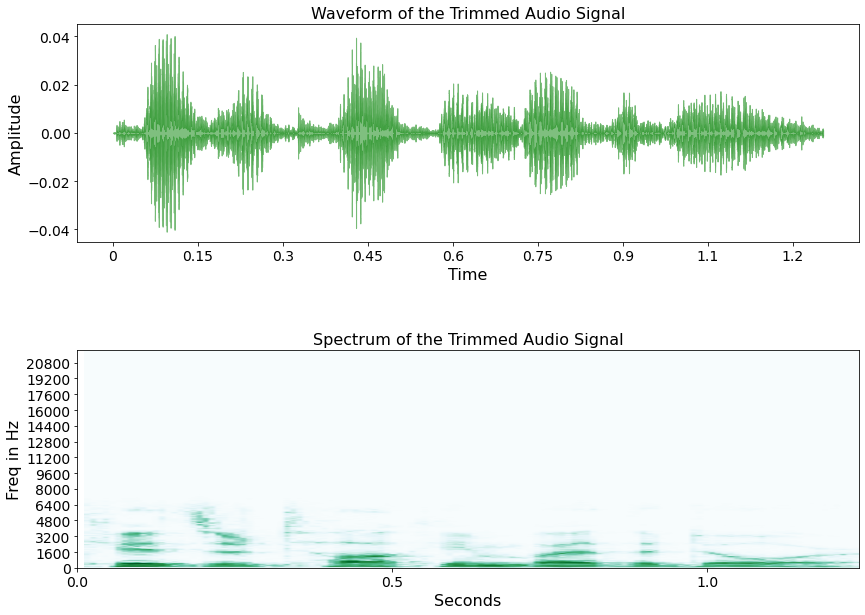

In [ ]:
freqs, times, spectograms = plotSpectogram(trimmedSamples, sample_rate)


fig = plt.figure(figsize=(14,10));
ax1 = fig.add_subplot(211);
ax1.set_title("Waveform of the Trimmed Audio Signal");
ax1.set_ylabel("Amplitude");
librosa.display.waveshow(trimmedSamples, sr=sample_rate, color="Green", alpha=0.5);
fig.subplots_adjust(hspace=0.5);
ax2 = fig.add_subplot(212);
ax2.imshow(spectograms.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()], cmap="BuGn");
ax2.set_yticks(freqs[::32])
start, end = ax2.get_xlim();
ax2.xaxis.set_ticks(np.arange(0.0, end, 0.5));
ax2.set_title("Spectrum of the Trimmed Audio Signal");
ax2.set_ylabel("Freq in Hz");
ax2.set_xlabel("Seconds");

<h2><u>Filtering Trimmed Audio</u></h2>

<font size=3>After trimming, it can be seen that we have noise in the audio. We would isolate the noise from the audio using <strong>Wiener filter</strong>. It follows a process of estimating the desired or target random process by Linear time-invariant filtering and reduces the mean square error between the estimated random process and desired process.
</font>

In [ ]:
filteredSample = scipy.signal.wiener(trimmedSamples)
filteredSample.shape

(55296,)

In [ ]:
ipd.Audio(filteredSample, rate=sample_rate)

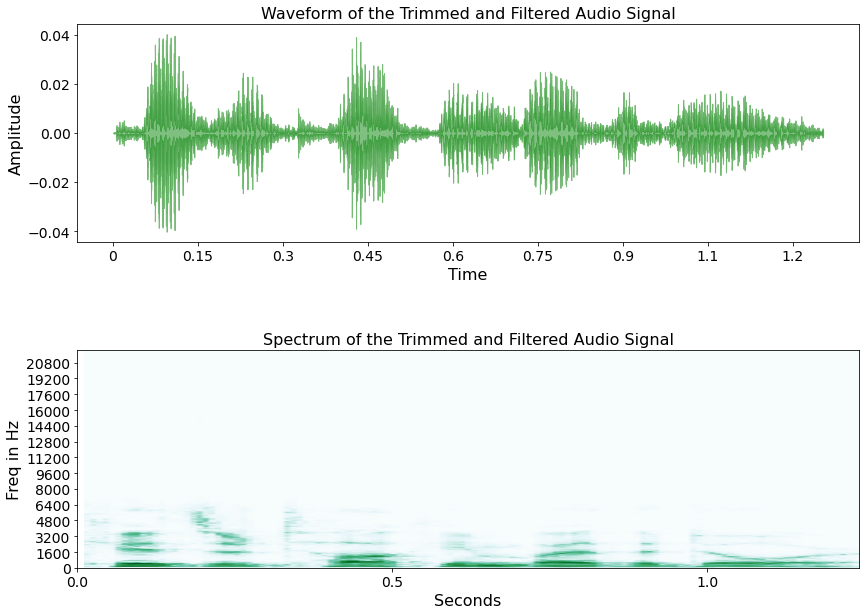

In [ ]:
freqs, times, spectograms = plotSpectogram(filteredSample, sample_rate)


fig = plt.figure(figsize=(14,10));
ax1 = fig.add_subplot(211);
ax1.set_title("Waveform of the Trimmed and Filtered Audio Signal");
ax1.set_ylabel("Amplitude");
librosa.display.waveshow(filteredSample, sr=sample_rate, color="Green", alpha=0.5);
fig.subplots_adjust(hspace=0.5);
ax2 = fig.add_subplot(212);
ax2.imshow(spectograms.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()], cmap="BuGn");
ax2.set_yticks(freqs[::32])
start, end = ax2.get_xlim();
ax2.xaxis.set_ticks(np.arange(0.0, end, 0.5));
ax2.set_title("Spectrum of the Trimmed and Filtered Audio Signal");
ax2.set_ylabel("Freq in Hz");
ax2.set_xlabel("Seconds");

In [ ]:
freqs.max()

22050.0

<h2><u>Noisy Audio</u></h3>

In [ ]:
noisySample = trimmedSamples - filteredSample
ipd.Audio(noisySample, rate=sample_rate)

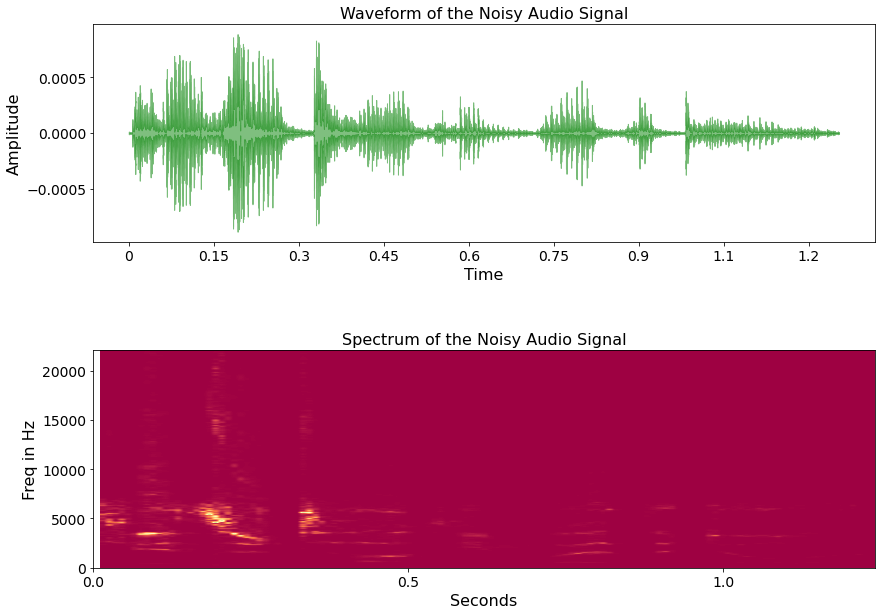

In [ ]:
freqs, times, spectograms = plotSpectogram(noisySample, sample_rate)


fig = plt.figure(figsize=(14,10));
ax1 = fig.add_subplot(211);
ax1.set_title("Waveform of the Noisy Audio Signal");
ax1.set_ylabel("Amplitude");
librosa.display.waveshow(noisySample, sr=sample_rate, color="Green", alpha=0.5)
fig.subplots_adjust(hspace=0.5);
ax2 = fig.add_subplot(212);
ax2.set_title("Spectrum of the Noisy Audio Signal");
ax2.set_ylabel("Freq in Hz");
ax2.set_xlabel("Seconds");
ax2.imshow(spectograms.T, aspect='auto', origin='lower', extent=[times.min(), times.max(), freqs.min(), freqs.max()], cmap="Spectral");
start, end = ax2.get_xlim();
ax2.xaxis.set_ticks(np.arange(0.0, end, 0.5));

<h2 align="center"><u>Feature Extraction</u></h2>

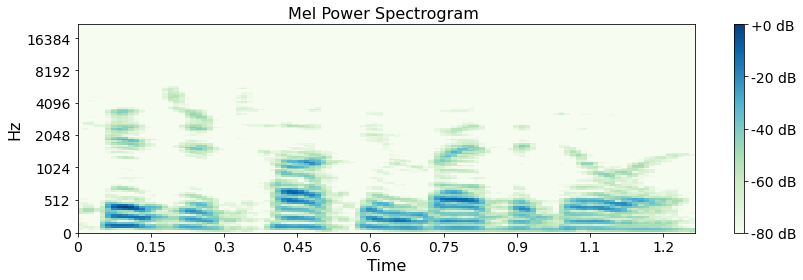

In [ ]:
MPS_sample = librosa.feature.melspectrogram(filteredSample, sr=sample_rate, n_mels=128, n_fft=2048, hop_length=512)

log_MPS_sample = librosa.amplitude_to_db(MPS_sample, ref=np.max)

plt.figure(figsize=(12, 4));
librosa.display.specshow(log_MPS_sample, sr=sample_rate, x_axis='time', y_axis='mel', cmap="GnBu");
plt.title('Mel Power Spectrogram ');
plt.colorbar(format='%+02.0f dB');
plt.tight_layout();

<font size=3>Mel Frequency Cepstral Coefficients are derived from Cepstrum which is 

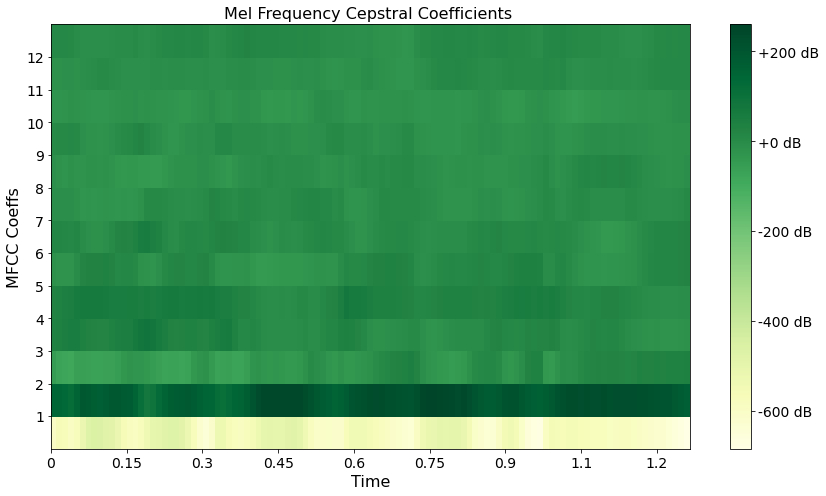

In [ ]:
mfcc_sample = librosa.feature.mfcc(filteredSample, sr=sample_rate)

plt.figure(figsize=(12, 7));
librosa.display.specshow(mfcc_sample[:13], sr=sample_rate, x_axis="time", cmap="YlGn");
plt.title('Mel Frequency Cepstral Coefficients ');
plt.ylabel("MFCC Coeffs")
plt.xlabel("Time")
plt.yticks(range(1,13,1))
plt.colorbar(format='%+02.0f dB');
plt.tight_layout();

In [ ]:
mfcc_sample.shape

(20, 109)

***

We clean the data from here after and use it to build a CNN model. 

***

In [ ]:
audioData.head()

,path,source,actor,gender,emotion,emotion_lb
0,/content/drive/My Drive/Speech Emotion Recogni...,Ravdess,1,male,1,neutral
1,/content/drive/My Drive/Speech Emotion Recogni...,Ravdess,1,male,1,neutral
2,/content/drive/My Drive/Speech Emotion Recogni...,Ravdess,1,male,1,neutral
3,/content/drive/My Drive/Speech Emotion Recogni...,Ravdess,1,male,1,neutral
4,/content/drive/My Drive/Speech Emotion Recogni...,Ravdess,1,male,1,neutral


In [ ]:
audioData.path[52]

'/content/drive/My Drive/Speech Emotion Recognition/ravdess-data//Actor_01/03-01-04-02-02-01-01.wav'

In [ ]:
finalAudioData = audioData.copy()

In [ ]:
finalAudioData.drop(finalAudioData.index[finalAudioData["emotion_lb"] == "surprised"], inplace=True)
finalAudioData.loc[(finalAudioData["emotion_lb"] == "calm"), ["emotion","emotion_lb"]]=1, "neutral"

In [ ]:
finalAudioData.head()

,path,source,actor,gender,emotion,emotion_lb
0,/content/drive/My Drive/Speech Emotion Recogni...,Ravdess,1,male,1,neutral
1,/content/drive/My Drive/Speech Emotion Recogni...,Ravdess,1,male,1,neutral
2,/content/drive/My Drive/Speech Emotion Recogni...,Ravdess,1,male,1,neutral
3,/content/drive/My Drive/Speech Emotion Recogni...,Ravdess,1,male,1,neutral
4,/content/drive/My Drive/Speech Emotion Recogni...,Ravdess,1,male,1,neutral


In [ ]:
finalAudioData["actor"] = finalAudioData["actor"].astype(int)

In [ ]:
finalAudioData["type"] = np.where((finalAudioData["actor"] == 23) | (finalAudioData["actor"] == 24), "test", 
                             np.where((finalAudioData["actor"] == 21) | (finalAudioData["actor"] == 22), "val", "train"))

In [ ]:
finalAudioData["type"].value_counts()

train    2080
val       208
test      208
Name: type, dtype: int64

In [ ]:
finalAudioData["emotgend_lb"] = finalAudioData.gender + "_" + finalAudioData.emotion_lb

In [ ]:
finalAudioData.index = range(len(finalAudioData))

In [ ]:
finalAudioData.shape

(2496, 8)

In [ ]:
finalAudioData.head()

,path,source,actor,gender,emotion,emotion_lb,type,emotgend_lb
0,/content/drive/My Drive/Speech Emotion Recogni...,Ravdess,1,male,1,neutral,train,male_neutral
1,/content/drive/My Drive/Speech Emotion Recogni...,Ravdess,1,male,1,neutral,train,male_neutral
2,/content/drive/My Drive/Speech Emotion Recogni...,Ravdess,1,male,1,neutral,train,male_neutral
3,/content/drive/My Drive/Speech Emotion Recogni...,Ravdess,1,male,1,neutral,train,male_neutral
4,/content/drive/My Drive/Speech Emotion Recogni...,Ravdess,1,male,1,neutral,train,male_neutral


In [ ]:
finalAudioData.emotion_lb.value_counts()

neutral    576
happy      384
sad        384
angry      384
fearful    384
disgust    384
Name: emotion_lb, dtype: int64

In [ ]:
input_length=sample_rate * 3
dataSample = np.zeros(input_length)
mfcc = librosa.feature.mfcc(dataSample, sr=sample_rate, n_mfcc=20)

In [ ]:
dataSample.shape

(132300,)

In [ ]:
mfcc.shape

(20, 259)

In [ ]:
np.mean(mfcc,axis=0)[:10]

array([-56.56854249, -56.56854249, -56.56854249, -56.56854249,
       -56.56854249, -56.56854249, -56.56854249, -56.56854249,
       -56.56854249, -56.56854249])

In [ ]:
from tqdm import tqdm_notebook as tqdm

In [ ]:
df_1d = pd.DataFrame(columns=["feature"])

In [ ]:
len(finalAudioData)

2496

In [ ]:
count_1d = 0

for i in tqdm(range(len(finalAudioData))):
  signal, sample_rate = librosa.load(finalAudioData.path[i], res_type="kaiser_fast", sr=sample_rate)
  mfccs = np.mean(librosa.feature.mfcc(signal, sample_rate, n_mfcc=13),axis=0)
  #feature = mfccs
  df_1d.loc[count_1d,"feature"] = mfccs
  count_1d+=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/2496 [00:00<?, ?it/s]

In [ ]:
final_df_1d = pd.DataFrame(df_1d.feature.values.tolist())

In [ ]:
print(final_df_1d.shape, finalAudioData["emotgend_lb"].shape)

(2496, 455) (2496,)


In [ ]:
final_df_1d.drop(columns=range(285,len(final_df_1d.columns)), axis=1, inplace=True)

In [ ]:
print(final_df_1d.shape, finalAudioData["emotgend_lb"].shape)

(2496, 285) (2496,)


In [ ]:
final_df_1d.loc[:,"emotgend_lb"] = finalAudioData["emotgend_lb"]

In [ ]:
final_df_1d.head()

,0,1,2,3,4,5,6,7,8,9,...,276,277,278,279,280,281,282,283,284,emotgend_lb
0,-65.798653,-65.798653,-65.798653,-65.798653,-65.798653,-65.798653,-65.798653,-65.798653,-65.798653,-65.798653,...,-65.798653,-65.798653,-65.798653,-65.798653,-65.798653,-65.798653,-65.798653,-65.798653,-65.798653,male_neutral
1,-65.798653,-65.798653,-65.798653,-65.798653,-65.798653,-65.798653,-65.798653,-65.798653,-65.798653,-65.798653,...,-65.798653,-65.798653,-65.798653,-65.798653,-65.798653,-65.798653,-65.798653,-65.798653,-65.798653,male_neutral
2,-65.418144,-65.418144,-65.418144,-65.418144,-65.418144,-65.418144,-65.418144,-65.418144,-64.904114,-60.873264,...,-65.418144,-63.383530,-65.396866,-65.418144,-65.418144,-65.418144,-65.418144,-65.418144,-65.418144,male_neutral
3,-65.418144,-65.418144,-65.418144,-65.418144,-65.418144,-65.418144,-65.418144,-65.418144,-64.904114,-60.873264,...,-65.418144,-63.383530,-65.396866,-65.418144,-65.418144,-65.418144,-65.418144,-65.418144,-65.418144,male_neutral
4,-58.280479,-57.780151,-56.864620,-55.928123,-53.429184,-54.940449,-59.519936,-63.189507,-59.439583,-55.248661,...,-57.915916,-57.448807,-60.168449,-63.617062,-58.594322,-55.751568,NaN,NaN,NaN,male_neutral


In [ ]:
final_df_1d.shape

(2496, 286)

In [ ]:
len(np.unique(final_df_1d["emotgend_lb"]))

12

In [ ]:
'''x_train_1d = final_df_1d[:len(final_df_1d.columns)-1]
y_train_1d = final_df_1d[::-1]'''

x_label = final_df_1d.columns[:-1]
y_label = final_df_1d.columns[-1:]

In [ ]:
print(final_df_1d[x_label].head())
print(final_df_1d[y_label].head())

         0          1          2          3          4          5    \
0 -65.798653 -65.798653 -65.798653 -65.798653 -65.798653 -65.798653   
1 -65.798653 -65.798653 -65.798653 -65.798653 -65.798653 -65.798653   
2 -65.418144 -65.418144 -65.418144 -65.418144 -65.418144 -65.418144   
3 -65.418144 -65.418144 -65.418144 -65.418144 -65.418144 -65.418144   
4 -58.280479 -57.780151 -56.864620 -55.928123 -53.429184 -54.940449   

         6          7          8          9    ...        275        276  \
0 -65.798653 -65.798653 -65.798653 -65.798653  ... -65.798653 -65.798653   
1 -65.798653 -65.798653 -65.798653 -65.798653  ... -65.798653 -65.798653   
2 -65.418144 -65.418144 -64.904114 -60.873264  ... -65.418144 -65.418144   
3 -65.418144 -65.418144 -64.904114 -60.873264  ... -65.418144 -65.418144   
4 -59.519936 -63.189507 -59.439583 -55.248661  ... -63.589272 -57.915916   

         277        278        279        280        281        282  \
0 -65.798653 -65.798653 -65.798653 -65.798653

In [ ]:
x_train_1d, x_test_1d, y_train_1d, y_test_1d = train_test_split(final_df_1d[x_label], final_df_1d[y_label], test_size=0.20, random_state=12)
'''x_train_1d = np.array(train_data.iloc[:, ])
y_train_1d = np.array(train_data[:, -1:])
x_test_1d = np.array(test_data[:, :-1])
y_test_1d = np.array(test_data[:, -1:])'''

'x_train_1d = np.array(train_data.iloc[:, ])\ny_train_1d = np.array(train_data[:, -1:])\nx_test_1d = np.array(test_data[:, :-1])\ny_test_1d = np.array(test_data[:, -1:])'

In [ ]:
x_train_1d[:2]

,0,1,2,3,4,5,6,7,8,9,...,275,276,277,278,279,280,281,282,283,284
883,-61.869724,-63.029800,-63.339592,-62.710136,-61.185520,-60.969257,-61.490883,-57.500923,-59.911312,-67.570892,...,-45.237953,-51.569820,-55.444111,-55.764633,-52.709824,-51.056053,-52.806156,-55.635983,-58.197823,-55.687767
602,-41.992649,-42.297649,-41.809910,-41.642021,-41.613121,-41.871040,-42.565315,-42.659599,-42.247643,-42.189247,...,-38.032192,-38.980251,-38.278732,-37.773945,-39.029308,-37.854130,-39.137337,-39.066841,-40.294060,-41.447464


In [ ]:
x_train_1d.fillna(np.mean(x_train_1d), inplace=True)
x_test_1d.fillna(np.mean(x_test_1d), inplace=True)

In [ ]:
x_train_1d.shape

(1996, 285)

In [ ]:
'''print(sum(x_train_1d.isna()))
print(sum(x_test_1d.isna()))'''

x_train_1d = np.array(x_train_1d).astype(np.int)
x_test_1d = np.array(x_test_1d).astype(np.int)
y_train_1d = np.array(y_train_1d)
y_test_1d = np.array(y_test_1d)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note lin

In [ ]:
lb = LabelEncoder()
y_train_1d_cnn = to_categorical(lb.fit_transform(y_train_1d))
y_test_1d_cnn = to_categorical(lb.fit_transform(y_test_1d))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
x_train_1d.shape

(1996, 285)

In [ ]:
x_train_1d_cnn = np.expand_dims(x_train_1d, axis=2)
x_test_1d_cnn = np.expand_dims(x_test_1d, axis=2)

In [ ]:
x_train_1d_cnn.shape

(1996, 285, 1)

In [ ]:
print(x_train_1d_cnn.shape, y_train_1d_cnn.shape, x_test_1d_cnn.shape, y_test_1d_cnn.shape)

(1996, 285, 1) (1996, 12) (500, 285, 1) (500, 12)


In [ ]:
cnn_1d_model = Sequential()

cnn_1d_model.add(Conv1D(filters=256, kernel_size=5, strides=1, padding="same", input_shape=(285,1)))
cnn_1d_model.add(Activation("relu"))
#model.add(MaxPooling1D(pool_size=4))
#model.add(Dropout(0.5))

cnn_1d_model.add(Conv1D(filters=128, kernel_size=5, strides=1, padding="same"))
cnn_1d_model.add(Activation("relu"))
cnn_1d_model.add(Dropout(0.5))
cnn_1d_model.add(MaxPooling1D(pool_size=4))
#model.add(Dropout(0.25))

cnn_1d_model.add(Conv1D(filters=128, kernel_size=5, strides=1, padding="same"))
cnn_1d_model.add(Activation("relu"))
#model.add(MaxPooling1D(pool_size=4))
#model.add(Dropout(0.25))

cnn_1d_model.add(Conv1D(filters=128, kernel_size=5, strides=1, padding="same"))
cnn_1d_model.add(Activation("relu"))

cnn_1d_model.add(Flatten())

cnn_1d_model.add(Dense(len(np.unique(final_df_1d["emotgend_lb"]))))
cnn_1d_model.add(Activation("softmax"))

In [ ]:
cnn_1d_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 285, 256)          1536      
                                                                 
 activation (Activation)     (None, 285, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 285, 128)          163968    
                                                                 
 activation_1 (Activation)   (None, 285, 128)          0         
                                                                 
 dropout (Dropout)           (None, 285, 128)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 71, 128)          0         
 )                                                               
                                                        

In [ ]:
cnn_1d_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001, decay=1e-6), loss=["categorical_crossentropy"], metrics=["categorical_accuracy"])

In [ ]:
cnn_1d_history = cnn_1d_model.fit(x_train_1d_cnn, y_train_1d_cnn, batch_size=16, epochs=100, validation_data=(x_test_1d_cnn, y_test_1d_cnn))

Epoch 1/100
125/125 [==============================] - 12s 9ms/step - loss: 2.7037 - categorical_accuracy: 0.1082 - val_loss: 2.4672 - val_categorical_accuracy: 0.1220
Epoch 2/100
125/125 [==============================] - 1s 6ms/step - loss: 2.4397 - categorical_accuracy: 0.1383 - val_loss: 2.2973 - val_categorical_accuracy: 0.2080
Epoch 3/100
125/125 [==============================] - 1s 6ms/step - loss: 2.3628 - categorical_accuracy: 0.1769 - val_loss: 2.1617 - val_categorical_accuracy: 0.3000
Epoch 4/100
125/125 [==============================] - 1s 6ms/step - loss: 2.2625 - categorical_accuracy: 0.2189 - val_loss: 2.2272 - val_categorical_accuracy: 0.2560
Epoch 5/100
125/125 [==============================] - 1s 6ms/step - loss: 2.0783 - categorical_accuracy: 0.2836 - val_loss: 2.2395 - val_categorical_accuracy: 0.2480
Epoch 6/100
125/125 [==============================] - 1s 6ms/step - loss: 1.8933 - categorical_accuracy: 0.3542 - val_loss: 2.0517 - val_categorical_accuracy: 0.29

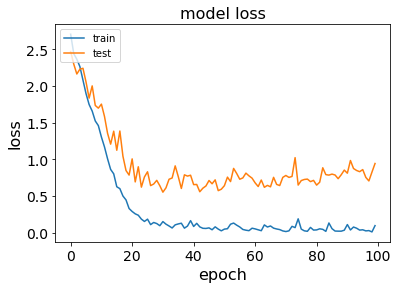

In [ ]:
plt.plot(cnn_1d_history.history['loss'])
plt.plot(cnn_1d_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

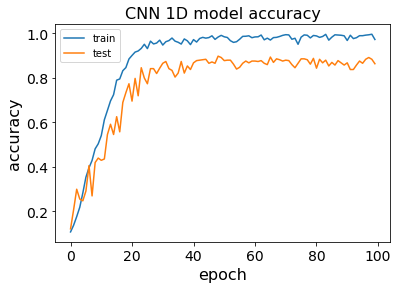

In [ ]:
plt.plot(cnn_1d_history.history['categorical_accuracy'])
plt.plot(cnn_1d_history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
max(cnn_1d_history.history['val_categorical_accuracy'])*100

89.80000019073486

In [ ]:
model_name = "CNN_1D.h5"
save_dir = os.path.join(os.getcwd(), "Models")
if not os.path.isdir(save_dir):
  os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name)
cnn_1d_model.save(model_path)

In [ ]:
import json
model_json = cnn_1d_model.to_json()
with open("cnn_1d_model.json", "w") as model_file:
  model_file.write(model_json)

In [ ]:
from keras.models import model_from_json

json_file = open("cnn_1d_model.json", "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model_1d = model_from_json(loaded_model_json)
# load weights into new model
loaded_model_1d.load_weights("Models/CNN_1D.h5")
 
# evaluate loaded model on test data
loaded_model_1d.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['categorical_accuracy'])
score = loaded_model_1d.evaluate(x_test_1d_cnn, y_test_1d_cnn, verbose=0)
print("%s: %.2f%%" % (loaded_model_1d.metrics_names[1], score[1]*100))

categorical_accuracy: 86.40%


***
### 2D CNN model building starts from here.
***

In [ ]:
audios = np.empty(shape=(finalAudioData.shape[0], 128, mfcc.shape[1],1))

count = 0
for i in tqdm(range(0, len(finalAudioData))):
    signal, sample_rate = librosa.load(finalAudioData.path[i], res_type="kaiser_fast", sr=sample_rate)
    trimmedSignal, index = librosa.effects.trim(signal, top_db=25)
    filteredSignal = scipy.signal.wiener(trimmedSignal)
    
    if len(filteredSignal) > input_length:
        filteredSignal = filteredSignal[0:input_length]
    elif input_length > len(filteredSignal):
        max_offset = input_length - len(filteredSignal)
        filteredSignal = np.pad(filteredSignal, (0,max_offset), "constant")
        #filteredSignal = filteredSignal[0:len(filteredSignal)]
        
    MPS_sample = librosa.feature.melspectrogram(filteredSignal, sr=sample_rate, n_mels=128, n_fft=2048, hop_length=512)
    log_MPS_sample = librosa.amplitude_to_db(MPS_sample)
    log_expandDime = np.expand_dims(log_MPS_sample, axis=-1)
    audios[count,] = log_expandDime
    count+=1
        
        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/2496 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scipy/signal/signaltools.py:1456: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/usr/local/lib/python3.7/dist-packages/scipy/signal/signaltools.py:1456: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


In [ ]:
finalAudioData.path[i]

'/content/drive/My Drive/Speech Emotion Recognition/ravdess-data//Actor_24/03-01-07-02-02-02-24.wav'

In [ ]:
finalAudioData["type"].value_counts()

train    2080
val       208
test      208
Name: type, dtype: int64

In [ ]:
audios.shape

(2496, 128, 259, 1)

In [ ]:
import h5py
with h5py.File('Ravdess_audio_Mel_spec.h5', 'w') as hf:
    hf.create_dataset("Ravdess_audio_Mel_spec",  data=audios)

In [ ]:
import h5py
with h5py.File('Ravdess_audio_Mel_spec.h5', 'r') as hf:
  audios = hf['Ravdess_audio_Mel_spec'][:]

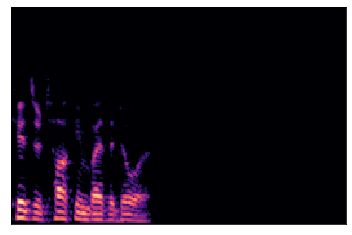

In [ ]:
librosa.display.specshow(audios[0].reshape(128,259))

In [ ]:
x_train = audios[(finalAudioData["type"] == "train")]
y_train = finalAudioData.emotgend_lb[(finalAudioData["type"] == "train")]

x_test = audios[(finalAudioData["type"] == "val")]
y_test = finalAudioData.emotgend_lb[(finalAudioData["type"] == "val")]

In [ ]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(2080, 128, 259, 1) (2080,)
(208, 128, 259, 1) (208,)


In [ ]:
x_train_2d_cnn = np.array(x_train)
y_train = np.array(y_train)
x_test_2d_cnn = np.array(x_test)
y_test = np.array(y_test)

lb = LabelEncoder()
y_train_2d_cnn = to_categorical(lb.fit_transform(y_train))
y_test_2d_cnn = to_categorical(lb.fit_transform(y_test))

In [ ]:
print(x_test_2d_cnn.shape, y_test_2d_cnn.shape)

(208, 128, 259, 1) (208, 12)


In [ ]:
num_classes = len(np.unique(np.argmax(y_train_2d_cnn,1)))

In [ ]:
num_classes

12

In [ ]:
'''def build_model(hp):
  model = keras.Sequential([
                keras.layers.Conv2D(
                    filters=hp.Int("conv2D_filter1",min_value=32, max_value=128),
                    kernel_size=hp.Choice("conv2D_kernel1",values=[3,5]),
                    strides=(1,1),
                    data_format="channels_first",
                    padding="same",
                    input_shape=x_train.shape[1:]),
                keras.layers.BatchNormalization(),
                keras.layers.Activation("elu"),
                keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
                keras.layers.Dropout(0.5),

                keras.layers.Conv2D(
                    filters=hp.Int("conv2D_filter2",min_value=32, max_value=128),
                    kernel_size=hp.Choice("conv2D_kernel2",values=[3,5]),
                    strides=(1,1),
                    padding="same"),
                keras.layers.BatchNormalization(),
                keras.layers.Activation("elu"),
                keras.layers.MaxPooling2D(pool_size=(4,4), strides=(4,4)),
                keras.layers.Dropout(0.25),

                keras.layers.Conv2D(
                    filters=hp.Int("conv2D_filter1",min_value=32, max_value=64),
                    kernel_size=hp.Choice("conv2D_kernel1",values=[3,5]),
                    strides=(1,1),
                    padding="same"),
                keras.layers.BatchNormalization(),
                keras.layers.Activation("elu"),
                keras.layers.MaxPooling2D(pool_size=(4,4), strides=(4,4)),
                keras.layers.Dropout(0.25),

                keras.layers.Conv2D(
                    filters=hp.Int("conv2D_filter1",min_value=32, max_value=64),
                    kernel_size=hp.Choice("conv2D_kernel1",values=[3,5]),
                    strides=(1,1),
                    padding="same"),
                keras.layers.BatchNormalization(),
                keras.layers.Activation("elu"),
                #keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
                keras.layers.Dropout(0.25),

                keras.layers.Flatten(),
                keras.layers.Dense(num_classes, activation="softmax")
        ])
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-2,1e-3,1e-4])),
                                                loss="categorical_crossentropy",
                                                metrics=["categorical_accuracy"])
  return model'''

'def build_model(hp):\n  model = keras.Sequential([\n                keras.layers.Conv2D(\n                    filters=hp.Int("conv2D_filter1",min_value=32, max_value=128),\n                    kernel_size=hp.Choice("conv2D_kernel1",values=[3,5]),\n                    strides=(1,1),\n                    data_format="channels_first",\n                    padding="same",\n                    input_shape=x_train.shape[1:]),\n                keras.layers.BatchNormalization(),\n                keras.layers.Activation("elu"),\n                keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),\n                keras.layers.Dropout(0.5),\n\n                keras.layers.Conv2D(\n                    filters=hp.Int("conv2D_filter2",min_value=32, max_value=128),\n                    kernel_size=hp.Choice("conv2D_kernel2",values=[3,5]),\n                    strides=(1,1),\n                    padding="same"),\n                keras.layers.BatchNormalization(),\n                keras.layers.

In [ ]:
'''from keras_tuner import RandomSearch
tuner = RandomSearch(build_model,
                     objective="val_categorical_accuracy",
                     max_trials=10,
                     directory="../output")

tuner.search(x_train, y_train, epochs=20, validation_split=0.1)'''

'from keras_tuner import RandomSearch\ntuner = RandomSearch(build_model,\n                     objective="val_categorical_accuracy",\n                     max_trials=10,\n                     directory="../output")\n\ntuner.search(x_train, y_train, epochs=20, validation_split=0.1)'

In [ ]:
'''temp_model = tuner.get_best_models(num_models=1)[0]'''

'temp_model = tuner.get_best_models(num_models=1)[0]'

In [ ]:
'''temp_model.summary()'''

'temp_model.summary()'

In [ ]:
'''temp_modelhistory = temp_model.fit(x_train, y_train, batch_size=16, epochs=200, validation_data=(x_test,y_test))'''

'temp_modelhistory = temp_model.fit(x_train, y_train, batch_size=16, epochs=200, validation_data=(x_test,y_test))'

In [ ]:
'''max(temp_modelhistory.history["val_categorical_accuracy"])*100'''

'max(temp_modelhistory.history["val_categorical_accuracy"])*100'

In [ ]:
# CNN I/P Config
num_classes = len(np.unique(np.argmax(y_train_2d_cnn, 1)))
input_shape = x_train_2d_cnn.shape[1:]

In [ ]:
cnn_2d_model = Sequential(name="Speech_CNN2D")


cnn_2d_model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', data_format='channels_last',input_shape=input_shape))
cnn_2d_model.add(BatchNormalization())
cnn_2d_model.add(Activation('elu'))
cnn_2d_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
cnn_2d_model.add(Dropout(0.5))

cnn_2d_model.add(Conv2D(filters=128,kernel_size=(3,3), strides=(1,1), padding='same'))
cnn_2d_model.add(BatchNormalization())
cnn_2d_model.add(Activation('elu'))
cnn_2d_model.add(MaxPooling2D(pool_size=(4,4), strides=(4,4)))
cnn_2d_model.add(Dropout(0.25))

cnn_2d_model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'))
cnn_2d_model.add(BatchNormalization())
cnn_2d_model.add(Activation('elu'))
cnn_2d_model.add(MaxPooling2D(pool_size=(4,4), strides=(4,4)))
cnn_2d_model.add(Dropout(0.25))

cnn_2d_model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'))
cnn_2d_model.add(BatchNormalization())
cnn_2d_model.add(Activation('elu'))
cnn_2d_model.add(MaxPooling2D(pool_size=(4,4), strides=(4,4)))
cnn_2d_model.add(Dropout(0.25))

cnn_2d_model.add(Flatten())
# FC
cnn_2d_model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt = tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,  beta_2=0.999, amsgrad=False)
cnn_2d_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
cnn_2d_model.summary()

Model: "Speech_CNN2D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 259, 128)     1280      
                                                                 
 batch_normalization (BatchN  (None, 128, 259, 128)    512       
 ormalization)                                                   
                                                                 
 activation_5 (Activation)   (None, 128, 259, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 129, 128)     0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 64, 129, 128)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 129, 128)     

In [ ]:
print(x_train_2d_cnn.shape, y_train_2d_cnn.shape)
print(x_test_2d_cnn.shape, y_test_2d_cnn.shape)

(2080, 128, 259, 1) (2080, 12)
(208, 128, 259, 1) (208, 12)


In [ ]:
#Train Config

batch_size = 16
num_epochs = 200

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.0001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/content/gdrive/My Drive/Speech Emotion Recognition/Models/Audio_2DCNN_4L.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnn_2d_history=cnn_2d_model.fit(x_train_2d_cnn, y_train_2d_cnn, batch_size=batch_size, epochs=num_epochs,validation_data=(x_test_2d_cnn, y_test_2d_cnn), callbacks=[mcp_save, lr_reduce])


Epoch 1/200
130/130 [==============================] - 5s 35ms/step - loss: 2.7153 - categorical_accuracy: 0.1803 - val_loss: 2.2465 - val_categorical_accuracy: 0.3269 - lr: 0.0010
Epoch 2/200
130/130 [==============================] - 4s 33ms/step - loss: 2.1971 - categorical_accuracy: 0.2442 - val_loss: 1.9255 - val_categorical_accuracy: 0.3750 - lr: 0.0010
Epoch 3/200
130/130 [==============================] - 4s 33ms/step - loss: 2.0028 - categorical_accuracy: 0.2885 - val_loss: 2.2328 - val_categorical_accuracy: 0.1827 - lr: 0.0010
Epoch 4/200
130/130 [==============================] - 4s 33ms/step - loss: 1.8400 - categorical_accuracy: 0.3337 - val_loss: 2.4928 - val_categorical_accuracy: 0.1154 - lr: 0.0010
Epoch 5/200
130/130 [==============================] - 4s 32ms/step - loss: 1.7611 - categorical_accuracy: 0.3678 - val_loss: 2.4607 - val_categorical_accuracy: 0.0769 - lr: 0.0010
Epoch 6/200
130/130 [==============================] - 4s 33ms/step - loss: 1.6627 - categorica

In [ ]:
max(cnn_2d_history.history["val_categorical_accuracy"])*100

62.5

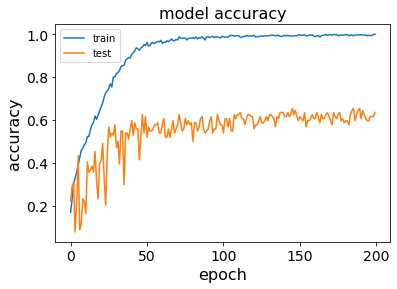

In [ ]:
plt.plot(cnn_2d_history.history['categorical_accuracy'])
plt.plot(cnn_2d_history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

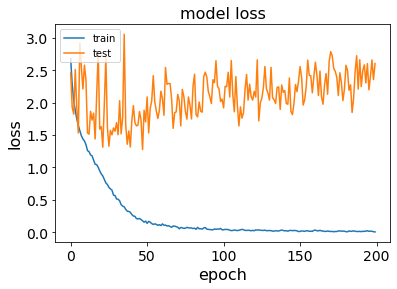

In [ ]:
plt.plot(cnn_2d_history.history['loss'])
plt.plot(cnn_2d_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model_name = "CNN_2D.h5"
save_dir = os.path.join(os.getcwd(), "Models")
if not os.path.isdir(save_dir):
  os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name)
cnn_2d_model.save(model_path)

import json
model_json = cnn_2d_model.to_json()
with open("cnn_2d_model.json", "w") as model_file:
  model_file.write(model_json)

from keras.models import model_from_json

json_file = open("cnn_2d_model.json", "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model_2d = model_from_json(loaded_model_json)
# load weights into new model
loaded_model_2d.load_weights("Models/CNN_2D.h5")
 
# evaluate loaded model on test data
loaded_model_2d.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['categorical_accuracy'])
score = loaded_model_2d.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model_2d.metrics_names[1], score[1]*100))

categorical_accuracy: 63.46%
